74000

=== Fold 1/5 ===


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Train Acc: 44.64%, Val Acc: 58.27%, LR: 0.000815
Epoch [2/25], Train Acc: 62.34%, Val Acc: 67.81%, LR: 0.001988
Epoch [3/25], Train Acc: 68.61%, Val Acc: 71.96%, LR: 0.003717
Epoch [4/25], Train Acc: 71.16%, Val Acc: 75.63%, LR: 0.005702
Epoch [5/25], Train Acc: 72.60%, Val Acc: 78.59%, LR: 0.007601
Epoch [6/25], Train Acc: 74.23%, Val Acc: 78.80%, LR: 0.009084
Epoch [7/25], Train Acc: 75.95%, Val Acc: 79.30%, LR: 0.009895
Epoch [8/25], Train Acc: 77.99%, Val Acc: 82.39%, LR: 0.009980
Epoch [9/25], Train Acc: 79.51%, Val Acc: 81.96%, LR: 0.009820
Epoch [10/25], Train Acc: 81.33%, Val Acc: 86.64%, LR: 0.009505
Epoch [11/25], Train Acc: 83.14%, Val Acc: 85.48%, LR: 0.009045
Epoch [12/25], Train Acc: 83.94%, Val Acc: 87.34%, LR: 0.008455
Epoch [13/25], Train Acc: 85.54%, Val Acc: 88.41%, LR: 0.007754
Epoch [14/25], Train Acc: 87.04%, Val Acc: 87.19%, LR: 0.006965
Epoch [15/25], Train Acc: 88.12%, Val Acc: 89.64%, LR: 0.006112
Epoch [16/25], Train Acc: 89.63%, Val Acc: 89.41%

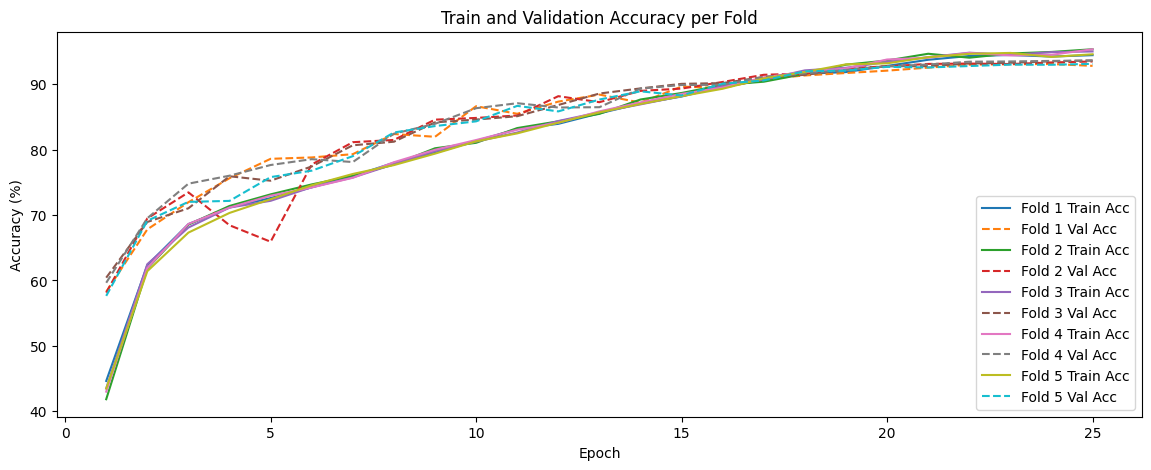

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms, datasets, models
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# 1. 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터 전처리 설정
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

augment1 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

augment2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

# 3. 데이터셋 로드
trainset_path = "C:/Users/USER/Desktop/Semester2/train_data"
user_dataset = datasets.ImageFolder(root=trainset_path, transform=basic_transform)

cifar10 = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=basic_transform)
cifar10_dataset1 = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=augment1)
cifar10_dataset2 = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=augment2)

# 4. 랜덤하게 10,000장씩 선택
num_samples = 10000
indices1 = np.random.choice(len(cifar10_dataset1), num_samples, replace=False)
indices2 = np.random.choice(len(cifar10_dataset2), num_samples, replace=False)
cifar10_dataset1 = Subset(cifar10_dataset1, indices1)
cifar10_dataset2 = Subset(cifar10_dataset2, indices2)

# 5. 데이터셋 결합
combined_dataset = ConcatDataset([user_dataset, cifar10, cifar10_dataset1, cifar10_dataset2])
combined_labels = np.concatenate((np.array([label for _, label in user_dataset.samples]),
                                  np.array(cifar10.targets),
                                  np.array(cifar10.targets)[indices1],  # 선택된 인덱스의 라벨
                                  np.array(cifar10.targets)[indices2]))

print(len(combined_dataset))

# 6. CutMix를 적용하는 함수
def cutmix_data(input, target, beta=1.0):
    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(input.size()[0]).to(device)
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
    input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size(-1) * input.size(-2)))
    return input, target_a, target_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

# 7. K-Fold Cross Validation 설정
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
num_epochs = 25
batch_size = 32
cutmix_prob = 0.1
train_accuracies, val_accuracies = [], []

# 8. 모델 학습 및 검증 루프
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(combined_labels)), combined_labels)):
    print(f"\n=== Fold {fold + 1}/{k} ===")
    train_subset = Subset(combined_dataset, train_idx)
    val_subset = Subset(combined_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)  # 초기 학습률을 약간 높게 설정

    # 학습률 스케줄러 설정 (OneCycleLR)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(train_loader))

    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        model.train()
        correct_train, total_train = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # CutMix 적용 여부 결정
            r = np.random.rand(1)
            if r < cutmix_prob:
                inputs, target_a, target_b, lam = cutmix_data(inputs, targets)
                outputs = model(inputs)
                loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()  # 학습률 업데이트

            _, preds = outputs.max(1)
            correct_train += preds.eq(targets).sum().item()
            total_train += targets.size(0)

        train_acc = 100 * correct_train / total_train
        train_acc_history.append(train_acc)

        # 검증
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                correct_val += preds.eq(targets).sum().item()
                total_val += targets.size(0)

        val_acc = 100 * correct_val / total_val
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")

    train_accuracies.append(train_acc_history)
    val_accuracies.append(val_acc_history)

# 9. 학습 및 검증 정확도 시각화
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))
for i in range(k):
    plt.plot(epochs_range, train_accuracies[i], label=f'Fold {i+1} Train Acc')
    plt.plot(epochs_range, val_accuracies[i], label=f'Fold {i+1} Val Acc', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy per Fold')
plt.legend()
plt.show()

In [20]:
(val_accuracies[0][-1]+val_accuracies[1][-1]+val_accuracies[2][-1]+val_accuracies[3][-1]+val_accuracies[4][-1])/5

93.32972972972973

In [41]:
torch.save(model.state_dict(), "C:/Users/USER/Desktop/Semester2/Statistical-ML/Project3_TeamProject/complete_model.pth") # "C:/Users/USER/Desktop/Semester2/complete_model.pth"

In [72]:
model(torch.rand(1,3,24,24).to(device))

tensor([[-0.0167,  0.0075, -0.0082,  0.0068,  0.0044, -0.0118,  0.0241,  0.0040,
          0.0022,  0.0136]], device='cuda:0', grad_fn=<AddmmBackward0>)